In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3,InceptionResNetV2,Xception,DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create labels
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [4]:

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)):
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:00<00:00, 125.84it/s]


In [5]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [6]:

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [7]:

DenseNet121=DenseNet121(weights=None, include_top=False,input_shape=(image_size,image_size,3))


In [8]:
#train the model
tf.random.set_seed(79)
model = DenseNet121.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=DenseNet121.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [9]:
# summarize the model
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 80, 80, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1/conv[0][0]']         

In [10]:

# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 71s 102ms/step - loss: 1.1739 - accuracy: 0.5018 - val_loss: 0.8531 - val_accuracy: 0.6443
Epoch 2/70
348/348 [==============================] - 31s 88ms/step - loss: 0.9604 - accuracy: 0.6114 - val_loss: 0.6320 - val_accuracy: 0.7642
Epoch 3/70
348/348 [==============================] - 31s 89ms/step - loss: 0.7996 - accuracy: 0.6869 - val_loss: 0.5557 - val_accuracy: 0.7947
Epoch 4/70
348/348 [==============================] - 31s 89ms/step - loss: 0.6817 - accuracy: 0.7340 - val_loss: 0.5460 - val_accuracy: 0.7947
Epoch 5/70
348/348 [==============================] - 33s 94ms/step - loss: 0.5474 - accuracy: 0.7919 - val_loss: 0.5131 - val_accuracy: 0.8293
Epoch 6/70
348/348 [==============================] - 31s 88ms/step - loss: 0.4805 - accuracy: 0.8174 - val_loss: 0.3737 - val_accuracy: 0.8801
Epoch 7/70
348/348 [==============================] - 31s 89ms/step - loss: 0.3838 - accuracy: 0.8569 - val_loss: 0.2984 - val_accuracy

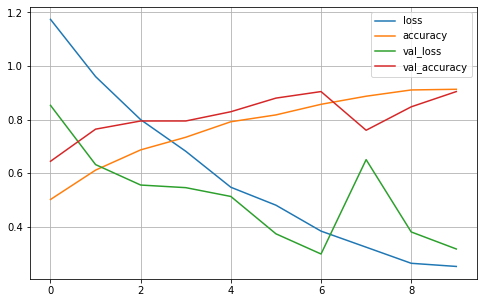

In [11]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [12]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 3s 124ms/step - loss: 0.2984 - accuracy: 0.9045


In [13]:
#print accuracy    
print('Accuracy: %f' % (accuracy*100))

Accuracy: 90.447152


In [14]:
#acuracy and loss
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 90.447 
 loss : 0.298


In [15]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)
#pred_labels

In [16]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    151
glioma_tumor        139
pituitary_tumor     129
no_tumor             73
dtype: int64

Text(70.8, 0.5, 'Predicted class')

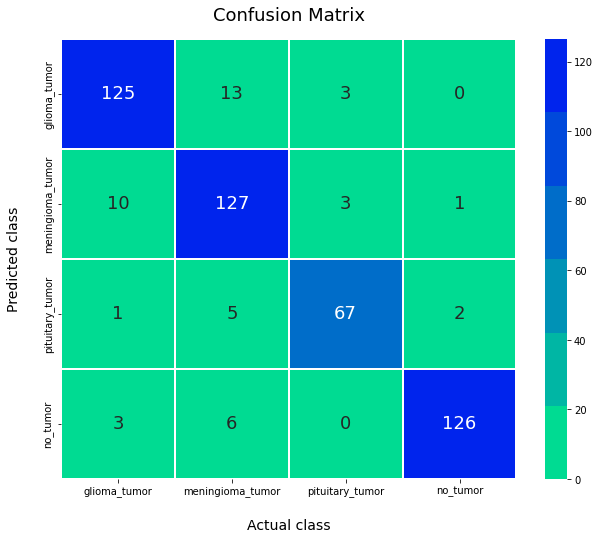

In [17]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)

ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)


In [18]:
#y_test_labels
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.89      0.89       141
meningioma_tumor       0.84      0.90      0.87       141
 pituitary_tumor       0.92      0.89      0.91        75
        no_tumor       0.98      0.93      0.95       135

        accuracy                           0.90       492
       macro avg       0.91      0.90      0.91       492
    weighted avg       0.91      0.90      0.91       492

